In [1]:
import utils
import gaussian_cal
import pandas as pd
import subprocess
import os
import time
name_list = ['S','A','EHOPA','AEPYridine','AEP','APN','DBE','DIPEDA','OA','mXD']
smiles_list = [
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(F)(F)F)F)F',
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(O)=O)F)F',
'CCCCC(CC)COCCCNC(C(F)(F)C1(F)OC(F)(F)C(F)(F)C1(C(F)(C(O)=O)F)F)=O',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCC2=CN=CC=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN2CCCCC2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NC2=CC(C#N)=CC(C#N)=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(CCCC)CCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(C(C)C)C(C)C)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCCCCCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCC2=CC(CN)=CC=C2)=O)F)O1',
]


In [2]:
for _ in name_list:
    try:
        os.system(f"cp -r CYTOP/{_}/* .")
    except:
        pass


In [6]:
G0 = gaussian_cal.GaussianCal(method='m062x',basis='6-311G(2d,p)',charge='neu',wfn=True,debug=True)
for i in range(len(name_list)):
    for j in range(200):
        if os.path.exists(f"{name_list[i]}{j}"):
            # if not utils.xyzcheck(f'{name_list[i]}{j}_0.xyz',smiles_list[i]):
            #     print(f"{name_list[
            # i]}{j}_0.xyz is not correct")
            #     continue
            while utils.i8cpu_running():
                time.sleep(60)
            G0.Run(f"{name_list[i]}{j}_0.xyz")

G1 = gaussian_cal.GaussianCal(method='m062x',basis='6-311G(2d,p)',charge='pos',wfn=True,debug=True)
for i in range(len(name_list)):
    for j in range(200):
        if os.path.exists(f"{name_list[i]}{j}"):
            # if not utils.xyzcheck(f'{name_list[i]}{j}_0.xyz',smiles_list[i]):
            #     print(f"{name_list[i]}{j}_0.xyz is not correct")
            #     continue
            while utils.i8cpu_running():
                time.sleep(60)
            G1.Run(f"{name_list[i]}{j}_0.xyz")

G2 = gaussian_cal.GaussianCal(method='m062x',basis='6-311G(2d,p)',charge='neg',wfn=True,debug=True)
for i in range(len(name_list)):
    for j in range(200):
        if os.path.exists(f"{name_list[i]}{j}"):
            # if not utils.xyzcheck(f'{name_list[i]}{j}_0.xyz',smiles_list[i]):
            #     print(f"{name_list[i]}{j}_0.xyz is not correct")
            #     continue
            while utils.i8cpu_running():
                time.sleep(60)
            G2.Run(f"{name_list[i]}{j}_0.xyz")



Submitted batch job 1693334
Submitted batch job 1693335
Submitted batch job 1693336
Submitted batch job 1693337
Submitted batch job 1693339
Submitted batch job 1693341
Submitted batch job 1693342
Submitted batch job 1693343
Submitted batch job 1693344
Submitted batch job 1693346
Submitted batch job 1693347
Submitted batch job 1693348
Submitted batch job 1693349
Submitted batch job 1693351
Submitted batch job 1693352
Submitted batch job 1693355
Submitted batch job 1693357
Submitted batch job 1693358
Submitted batch job 1693360
Submitted batch job 1693361
Submitted batch job 1693363
Submitted batch job 1693371
Submitted batch job 1693372
Submitted batch job 1693374
Submitted batch job 1693377
Submitted batch job 1693378
Submitted batch job 1693381
Submitted batch job 1693388
Submitted batch job 1693393
Submitted batch job 1693394
Submitted batch job 1693398
Submitted batch job 1693399
Submitted batch job 1693402
Submitted batch job 1693403
Submitted batch job 1693405
Submitted batch job 

In [49]:
from tqdm import tqdm

IP = []
IP_dict = {}
IP_name = []
for _ in name_list:
    for i in tqdm(range (200)):
        if os.path.exists(f"{_}{i}"):
            IP.append(float("{:.3f}".format((utils.IP_calculation((f"{_}{i}"))))))
            IP_name.append(f"{_}{i}")

In [62]:
EA = []
EA_dict = {}
EA_name = []
for _ in name_list:
    for i in tqdm(range (200)):
        if os.path.exists(f"{_}{i}"):
            EA.append(float("{:.3f}".format((utils.EA_calculation((f"{_}{i}"))))))
            EA_name.append(f"{_}{i}")

100%|██████████| 200/200 [00:01<00:00, 116.40it/s]


In [63]:
table = pd.DataFrame({'Name': IP_name, 'm062x/6-311G(2d,p) IP': IP, 'm062x/6-311G(2d,p) EA': EA})
table.to_csv('CYTOP_m062x_6-311G(2d,p)_IP_EA.csv', index=False)

In [ ]:
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', None)  # 显示完整行宽度
table

In [41]:
def time_calculation(log):
    with open(log, 'r') as file:
        for line in file:
            if "Job cpu time" in line:
                cpu_time = line.split(":")[1].strip()  # 获取冒号后面的部分并去除首尾空格
                day = cpu_time.split()[0]
                hour = cpu_time.split()[2]
                min = cpu_time.split()[4]
                sec = cpu_time.split()[6]
                cpu_time = int(day) * 24 * 60 + int(hour) * 60 + int(min)  + float(sec)/60
                return cpu_time

In [59]:
T1,T2,T_all = [],[],[]
time_dict = {}
for _ in name_list:
    for i in range(200):
        if os.path.exists(f"{_}{i}"):
            t1 = time_calculation(f"{_}{i}/{_}{i}_p1.log")
            t2 = time_calculation(f"{_}{i}/{_}{i}_0.log")
            T1.append(t1)
            T2.append(t2)
            T_all.append(t1+t2)
table = pd.DataFrame({'Name': IP_name, 'Tp': t1,'Tn':t2,'T':T_all})
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', None)  # 显示完整行宽度
table.to_csv('CYTOP_m062x_6-311G(2d,p)_time.csv', index=False)# max(time)
            

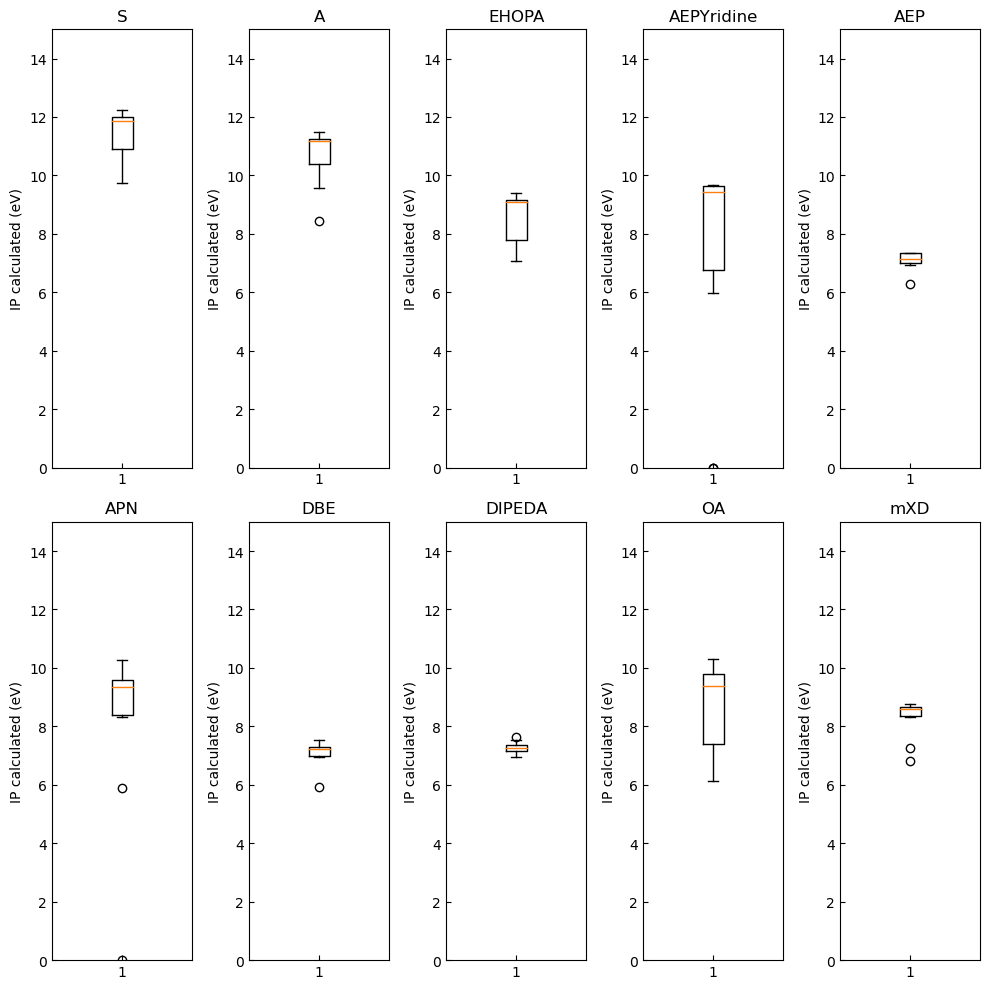

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# 示例数据，替换为你的IP值数据
# 统计描述

m062x_ip_dict_mean = {}
m062x_ip_dict_median = {}

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    m062x_ip_dict_mean[name_list[i]] = np.mean(IP[i*10:10*i+10])
    m062x_ip_dict_median[name_list[i]] = np.mean(IP[i*10:10*i+10])
    ax.boxplot(IP[i*10:10*i+10], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(0,15)
    ax.set_title(f'{name_list[i]}')
plt.tight_layout()
plt.savefig('CYTOP_m062x_6-311G(2d_p)_IP.png', dpi=300)

plt.show()



In [14]:
m062x_ip_dict


{'S': 11.459800000000001,
 'A': 10.658000000000001,
 'EHOPA': 8.5466,
 'AEPYridine': 7.256800000000001,
 'AEP': 7.0877,
 'APN': 8.086500000000001,
 'DBE': 7.0922,
 'DIPEDA': 7.287000000000001,
 'OA': 8.6704,
 'mXD': 8.2717}

In [15]:
P_sp = {    'S':0.135,
            'A':0.211,
            'EHOPA':0.686,
            'AEPYridine':0.855,
            'AEP':0.862,
            'APN':0.558,
            'DBE':0.746,
            'DIPEDA':0.715,
            'OA':0.576,
            'mXD':0.959,
        }

In [73]:
import csv
csv_file = 'data.csv'

# 将字典数据写入CSV文件
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 写入CSV文件的表头（如果需要）
    writer.writerow(['Name', 'm062x_6-311G(2d,p)_mean', 'm062x_6-311G(2d,p)_median''psp'])
    
    # 写入字典中的数据
    for key, value in m062x_ip_dict.items():
        writer.writerow([key, value, P_sp[key]])

In [60]:
def corrcoef(X,Y):
    x, y = [],[]
    for i in range(len(X)):
        x.append(X[list(X.keys())[i]])
        y.append(Y[list(Y.keys())[i]])
    plt.figure(figsize=(6.5, 6))
    plt.scatter(x, y)
    # 添加标签和标题
    plt.xlabel('Ionization Potential (eV)')
    plt.ylabel('Normalized charges after 200h')
    plt.title('Pearson Correlation')
    # 显示图表
    plt.show()
    return np.corrcoef(np.array(x),np.array(y))[0,1]

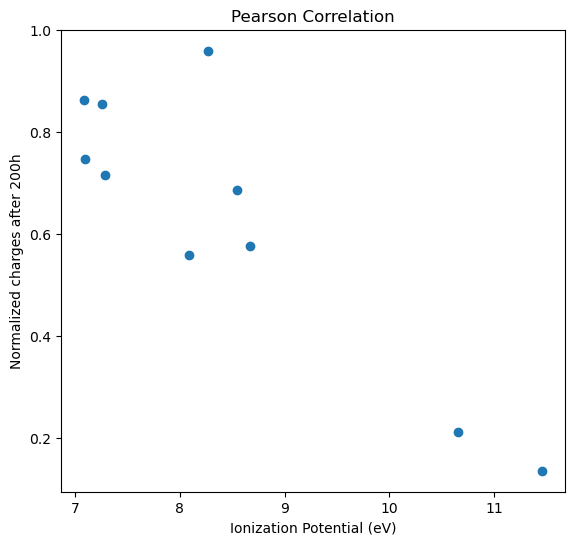

-0.8894061826268179

In [61]:
corrcoef(m062x_ip_dict,P_sp)

In [63]:
list(m062x_ip_dict.keys())[0]

'S'